### Reinforcement Learning Algorithm

- Algorithm : TD3
- Image 
 - shape : 84 x 84 x 4
 - style : skipping
- Output 
 - shape : 2 dimension 
 - style : r, theta

#### Library import

In [1]:
import os, sys, torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/home/lim/Artificial General Intelligence/')

In [3]:
from sys_util import makedir
from itertools import count
from game import RL_game, plot_image

pygame 2.1.2 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('=' * 50)
print('Device Name : {}'.format(device))
print('=' * 50)

Device Name : cuda


#### Replay_buffer

In [5]:
class Replay_buffer:
    def __init__(self, max_size = 50000):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0
        
    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] == data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)
    
    def sample(self, batch_size):
        index = np.random.randint(0, len(self.storage), size = batch_size)
        x, y, u, r, d = [], [], [], [], []
        
        for i in index:
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))
            
        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1, 1), np.array(d).reshape(-1, 1) 

#### Convolutional Neural Network

In [6]:
class ConvNet(nn.Module):
    def __init__(self, frame_size):
        super(ConvNet, self).__init__()
        
        self.frame_size = frame_size
        
        self.conv1 = nn.Conv2d(in_channels = 4, out_channels = 32, kernel_size = 8, stride = 4, padding = 'valid')
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 'valid')
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 'valid')
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = 7, stride = 1, padding = 'valid')
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(512, 256)
    
    def forward(self, x):
        x = x.reshape((-1, 4, self.frame_size, self.frame_size))
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return x

#### Actor Network

In [7]:
class Actor(nn.Module):
    def __init__(self, s_dim, model):
        super(Actor, self).__init__()
        self.conv = model
        
        self.fc1 = nn.Linear(s_dim, 200)
        self.fc2 = nn.Linear(200, 100)
        self.action_r = nn.Linear(100, 1)
        self.action_theta = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.conv(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        action_r = torch.sigmoid(self.action_r(x))
        action_theta = torch.tanh(self.action_theta(x))
        
        action = torch.cat([action_r, action_theta], dim=1)
        return action

#### Critic Network

In [8]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, model):
        super(Critic, self).__init__()
        self.conv = model
        
        self.fc1 = nn.Linear(s_dim + a_dim, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)
        
        self.fc4 = nn.Linear(s_dim + a_dim, 200)
        self.fc5 = nn.Linear(200, 100)
        self.fc6 = nn.Linear(100, 1)
    
    def forward(self, x, u):
        x = self.conv(x)
        
        x1 = F.relu(self.fc1(torch.cat([x, u], dim = 1)))
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        
        x2 = F.relu(self.fc4(torch.cat([x, u], dim = 1)))
        x2 = F.relu(self.fc5(x2))
        x2 = self.fc3(x2)
        return x1, x2
    
    def Q1(self, x, u):
        x = self.conv(x)
        
        x1 = F.relu(self.fc1(torch.cat([x, u], dim = 1)))
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        return x1

#### RL Algorithm

In [9]:
class TD3(object):
    def __init__(self, state_dim, action_dim, action_lr, critic_lr, model1, model2):
        self.actor = Actor(state_dim, model1).to(device)
        self.actor_target = Actor(state_dim, model1).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = action_lr)
        
        self.critic = Critic(state_dim, action_dim, model2).to(device)
        self.critic_target = Critic(state_dim, action_dim, model2).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        
        self.total_it = 0
        self.replay_buffer = Replay_buffer()
        
    def select_action(self, state, noise = 0.1):
        state = torch.FloatTensor(state).to(device)
        action_r, action_theta = self.actor(state).cpu().data.numpy().flatten()
        
        if noise != 0:
            action_r = (action_r + (np.random.normal(0, noise, size=1))).clip(0, 1)
            action_theta = (action_theta + (np.random.normal(0, noise * 2, size=1))).clip(-1, 1)
        
        action_r = torch.from_numpy(action_r).reshape(-1, 1)
        action_theta = torch.from_numpy(action_theta).reshape(-1, 1)
        
        action = torch.cat([action_r, action_theta], dim = 1)
        return action.cpu().data.numpy().flatten()
    
    def update(self, batch_size, iterations, discount = 0.99, tau = 0.005, policy_noise = 0.2, noise_clip = 0.5, policy_freq = 2):
        for it in range(iterations):
            x, y, u, r, d = self.replay_buffer.sample(batch_size)
            state = torch.FloatTensor(x).to(device)
            next_state = torch.FloatTensor(y).to(device)
            action = torch.FloatTensor(u).to(device)
            done = torch.FloatTensor(1-d).to(device)
            reward = torch.FloatTensor(r).to(device)
            
            with torch.no_grad():
                next_action = self.actor_target(next_state)
                
                r_noise = (torch.randn(size=(batch_size,)) * policy_noise / 2).clamp(-noise_clip/4, noise_clip/4).to(device)
                theta_noise = (torch.randn(size=(batch_size,)) * policy_noise).clamp(-noise_clip/2, noise_clip/2).to(device)
                
                next_action[:, 0] += r_noise
                next_action[:, 1] += theta_noise
                
                next_action[:, 0] = next_action[:, 0].clamp(0, 1)
                next_action[:, 1] = next_action[:, 1].clamp(-1, 1)
                
                target_Q1, target_Q2 = self.critic_target(next_state, next_action)
                target_Q = torch.min(target_Q1, target_Q2)
                target_Q = reward + (done * discount * target_Q).detach()
                
            current_Q1, current_Q2 = self.critic(state, action)
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
            
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            if it % policy_freq == 0:
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
                
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def save(self, directory, epoch):
        torch.save(self.actor, directory + '/Actor' + '/actor_{}.pt'.format(epoch))
        torch.save(self.critic, directory + '/Critic' + '/critic_{}.pt'.format(epoch))
        
        print('')
        print('=' * 50)
        print('Epoch : {} // Model has been saved...'.format(epoch))
        print('=' * 50)
    
    def load(self, directory, epoch, device):
        self.actor = torch.load(directory + '/Actor' + '/actor_{}.pt'.format(epoch), map_location=torch.device(device))
        self.critic = torch.load(directory + '/Critic' + '/critic_{}.pt'.format(epoch), map_location=torch.device(device))
        
        print('')
        print('=' * 50)
        print('Model has been loaded...')
        print('=' * 50)
        self.actor.eval()
        self.critic.eval()

#### parameter import

In [10]:
env = RL_game(mode = 'base')
frame_size = 84
state_dim = 256
action_dim = 2
action_lr = 1e-5
critic_lr = 1e-5
batch_size = 128
tau = 0.01
model1 = ConvNet(frame_size)
model2 = ConvNet(frame_size)

/home/lim/Artificial General Intelligence/game.py:127: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.action_r = gym.spaces.Box(low=np.float(0), high=np.float(act_high), shape=(1,))


In [11]:
max_episode = 100000
start_train = 100
trial = input('Name : ')
directory = makedir('/home/lim/Artificial General Intelligence/Data/RL_model', trial)

Name : TD3_frame_skip
Directory has been made...
Directory path : /home/lim/Artificial General Intelligence/Data/RL_model/TD3_frame_skip


In [12]:
path = np.load('/home/lim/Artificial General Intelligence/Data/total_path.npy')

[90  0]


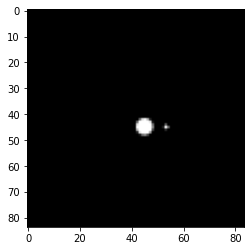

In [13]:
env.reset()
env.step(np.array([15]), np.array([0]), path)
print(env.action)
plt.imshow(env.to_frame(84, 84), cmap = 'gray')

#### Train

In [ ]:
agent = TD3(state_dim, action_dim, action_lr, critic_lr, model1, model2)
reward_list = []

for episode in range(max_episode):
    total_reward = 0
    step = 0
    env.reset()
    state = []
    
    for i in range(4):
        state.append(env.to_frame(frame_size, frame_size).squeeze().copy() / 255)
    state = np.array(state)
    
    for t in count():
        reward = 0
        
        if episode < start_train:
            action_r = (np.random.normal(0, 0.2, size=1)).clip(0, 1)
            action_theta = np.random.normal(0, 0.4, size=1).clip(-1, 1)
        else:
            action_r, action_theta = agent.select_action(state, noise = 0.1)
            action_r = np.array([action_r])
            action_theta = np.array([action_theta])
        
        next_state = []
        
        for _ in range(4):
            next_tmp, reward_tmp, done, _ = env.step(action_r, action_theta, path)
            next_tmp = env.to_frame(frame_size, frame_size).squeeze().copy() / 255
            next_state.append(next_tmp)
            reward += reward_tmp
        
        next_state = np.array(next_state)
        
        action = np.array([action_r.item(), action_theta.item()], dtype = float)
        agent.replay_buffer.push((state, next_state, action, reward, float(done)))
        state = next_state.copy()
        
        total_reward += reward
        
        if done:
            break
        
    print('\rEpisode : {}, Total_step : {}, Total Reward : {:.2f}'.format(episode, env.count, total_reward), end='')
    if episode == start_train:
        print('')
        print('=' * 50)
        print('***** Now Train begins. *****')
        print('=' * 50)
        
    reward_list.append(total_reward)
    
    if episode > start_train and total_reward == max(reward_list):
        agent.save(directory = directory, epoch = episode)
    
    if episode > start_train:
        agent.update(batch_size, episode)
    
    if total_reward > 29000:
        np.save(directory + '/{}_lr.npy'.format(trial), reward_list)
        break

Episode : 100, Total_step : 88, Total Reward : 31.037
***** Now Train begins. *****
Episode : 108, Total_step : 236, Total Reward : 130.44
Epoch : 108 // Model has been saved...
Episode : 111, Total_step : 248, Total Reward : 142.30
Epoch : 111 // Model has been saved...
Episode : 185, Total_step : 416, Total Reward : 89.795